LSTM (Long Short-Term Memory) to rodzaj sieci neuronowej rekurencyjnej (RNN), zaprojektowany specjalnie do uczenia się długoterminowych zależności. W przeciwieństwie do standardowych RNN, które mają problemy z zapamiętywaniem informacji przez długi czas, LSTM posiada specjalne mechanizmy, które pozwalają mu skutecznie przechowywać informacje przez dłuższe okresy.

Na początku programu dokonuje się importu wykorzystywanych bibliotek oraz wczytanie danych z pliku json, który zawiera informacje o cenach Bitcoina w określonym czasie. Dane te są umieszcane w strukturze danych pandas.

In [6]:
import json
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

jsonData = json.load(open('dailyBTC.json', encoding="utf-8"))
    
data = pd.DataFrame(jsonData['prices'][:data_size])
data.rename(columns={0: 'DateTime', 1: 'Price'}, inplace=True)

data.index = pd.to_datetime(data['DateTime'])
data = data.drop(columns=['DateTime'])


                 0             1
0    1644854619962  37728.533196
1    1644854904761  37806.563867
2    1644855315131  37795.844325
3    1644855612748  37891.227749
4    1644855886749  37865.753678
..             ...           ...
284  1644939888617  39009.158517
285  1644940143110  39037.731683
286  1644940419895  38990.516247
287  1644940680835  39007.761138
288  1644940815000  38998.026291

[289 rows x 2 columns]


Konfigurowalne wartości:

Długość sekwencji (seq_length) odnosi się do liczby przeszłych kroków czasowych w jednej sekwencji danych, które należy brać pod uwagę.

Epoka (epoch) - jeden pełny cykl przejścia przez cały zbiór treningowy. Podczas jednej epoki, model przetwarza każdą próbkę z danych treningowych dokładnie jeden raz.

Rozmiar wsadu (batch_size) - dane treningowe są często dzielone na mniejsze partie. zwane wsadami (batches). Rozmiar wsadu określa, ile próbek jest przetwarzanych przed aktualizacją wag. Liczba iteracji w jednej epoce jest równa liczbie wsadów.

Rozmiar danych - ilość danych wykorzystanych podczas wykonywania programu. W tym wypadku określa z jakiego okresu powinny zostać wykorzystane dane.


In [7]:
seq_length = 20
epochs = 100
batch_size = 40
data_size = 400

Normalizacja jest jest ważnym krokiem w przetwarzaniu danych przed treningiem modelu, ponieważ przyspiesza i stabilizuje proces uczenia.
- **MinMaxScaler()**: Skaluje dane do zakresu [0, 1] (domyślnie).
- **fit_transform(data)**: Dopasowuje skalera do danych i jednocześnie przekształca dane.
#### Wzór:
x' = x - min / (max - min)

In [ ]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

#### Podział danych na zbiory treningowe i testowe
- **train_size**: Liczba próbek w zbiorze treningowym (80% całego zestawu danych).
- **train_data**: Zbiór treningowy zawierający pierwsze 80% danych.
- **test_data**: Zbiór testowy zawierający pozostałe 20% danych.

In [8]:
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

### Tworzenie sekwencji

Sekwencje danych są tworzone do trenowania modelu LSTM.

#### Wyjaśnienie:
- **create_sequences(data, seq_length)**: Funkcja do tworzenia sekwencji danych i etykiet.
  - **X**: Lista sekwencji wejściowych.
  - **y**: Lista wartości docelowych (etykiet).
- **seq_length**: Długość każdej sekwencji.
- **np.array()**: Konwersja list na tablice numpy.

In [9]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

### Model LSTM

Tworzenie i kompilacja modelu LSTM:
- **tf.keras.Sequential**: Inicjalizuje sekwencyjny model Keras.
- **tf.keras.layers.LSTM(50, activation='relu', input_shape=(seq_length, 1))**: Dodaje warstwę LSTM z 50 jednostkami i funkcją aktywacji ReLU. **input_shape** określa kształt wejściowy (długość sekwencji, liczba cech).
- **tf.keras.layers.Dense(1)**: Dodaje w pełni połączoną warstwę wyjściową z jedną jednostką.
- **compile(optimizer='adam', loss='mean_absolute_error')**: Kompiluje model z optymalizatorem Adam i funkcją straty MAE.

In [10]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(50, activation='relu', input_shape=(seq_length, 1)),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mean_absolute_error')

Epoch 1/100
6/6 [==============================] - 1s 3ms/step - loss: 0.4090
Epoch 2/100
6/6 [==============================] - 0s 3ms/step - loss: 0.3251
Epoch 3/100
6/6 [==============================] - 0s 3ms/step - loss: 0.2196
Epoch 4/100
6/6 [==============================] - 0s 19ms/step - loss: 0.1055
Epoch 5/100
6/6 [==============================] - 0s 3ms/step - loss: 0.0986
Epoch 6/100
6/6 [==============================] - 0s 3ms/step - loss: 0.0857
Epoch 7/100
6/6 [==============================] - 0s 3ms/step - loss: 0.0646
Epoch 8/100
6/6 [==============================] - 0s 3ms/step - loss: 0.0564
Epoch 9/100
6/6 [==============================] - 0s 3ms/step - loss: 0.0488
Epoch 10/100
6/6 [==============================] - 0s 3ms/step - loss: 0.0444
Epoch 11/100
6/6 [==============================] - 0s 3ms/step - loss: 0.0436
Epoch 12/100
6/6 [==============================] - 0s 3ms/step - loss: 0.0434
Epoch 13/100
6/6 [==============================] - 0s 3ms/s

#### Trening modelu na zbiorze treningowym:
- **fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)**: Trenuje model na danych treningowych.
  - **epochs**: Liczba epok treningowych.
  - **batch_size**: Wielkość partii danych.
  - **verbose**: Poziom szczegółowości wypisywanych informacji podczas treningu (1 = szczegółowe informacje).

In [ ]:
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

### Przewidywanie wyników modelu ###

- **predict(x, batch_size, verbose, steps, callbacks)**: Podaje wyniki wytrenowane modelu na podstawie danych wejściowych
    - **x**: Dane wejściowe.
    - **batch_size**: Liczba próbek na wsad.
    - **verbose**: Rodzaj tekstu wywoływanego do terminalu (0 - nic, 1 - progress bar, 2 - pojedyncza linijka).
    - **steps**: Ilość kroków (wsadów próbek).
    - **callbacks**: Lista wywołań zwrotnych, jakie ma wywoływać program.

In [11]:
# Make predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Inverse transform the predictions
train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)

2/2 [==============================] - 0s 2ms/step


Wykorzystanie biblioteki matplotlib do prezentacji otrzymanych wyników. Tworzone są kolejno wykresy, które przedstawiają:
- dane faktyczne na badanym zbiorze danych
- predykcje na podstawie treningowych danych
- predykcje otrzymane z wykorzystaniem stworzonego modelu

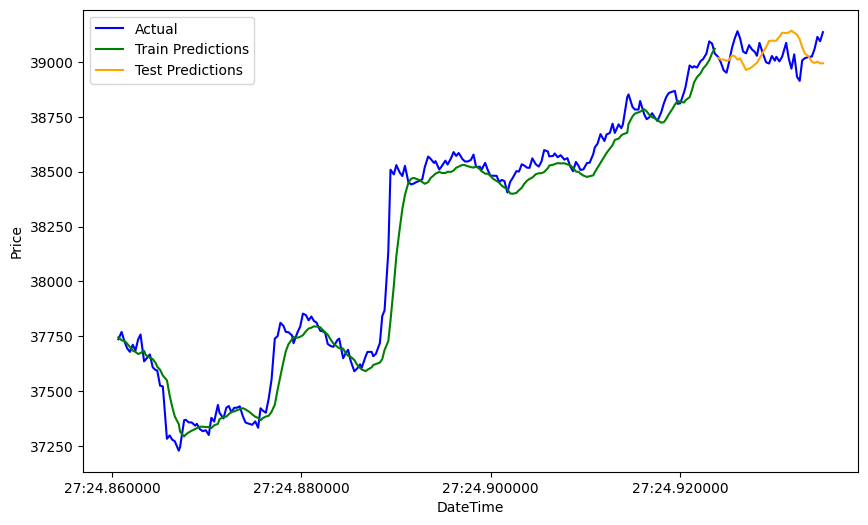

In [12]:
plt.figure(figsize=(10, 6))

plt.plot(data.index[seq_length:len(data)-seq_length], data['Price'][seq_length:len(data)-seq_length], label='Dane historyczne', color='black')
plt.plot(data.index[seq_length:seq_length+len(train_predictions)], train_predictions, label='Predykcje na podstawie danych testowych', color='blue')
plt.plot(data.index[range(seq_length+len(train_predictions), seq_length+len(train_predictions)+len(test_predictions))], test_predictions, label='Predykcje', color='red')

plt.xlabel('Czas')
plt.ylabel('Cena')
plt.legend()
plt.show()

### Źródła:
- https://www.geeksforgeeks.org/time-series-forecasting-using-tensorflow/
- https://en.wikipedia.org/wiki/Long_short-term_memory